# Fine-tuned SVM model for Speaker Identification



fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.
Extracting features...


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2020
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1455
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1359
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2045
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1858
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1556
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py

Encoding labels...
Splitting data...
Scaling features...
Tuning hyperparameters and training SVM classifier...
Best Parameters: {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf'}
Evaluating classifier...
Accuracy: 99.17%
Classification Report:
              precision    recall  f1-score   support

      george       1.00      1.00      1.00       110
     jackson       1.00      0.99      1.00       109
       lucas       1.00      1.00      1.00       106
     nicolas       1.00      1.00      1.00        98
        theo       0.97      0.98      0.97        89
    yweweler       0.98      0.98      0.98        88

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600

Saving model and scaler...
Visualizing confusion matrix...


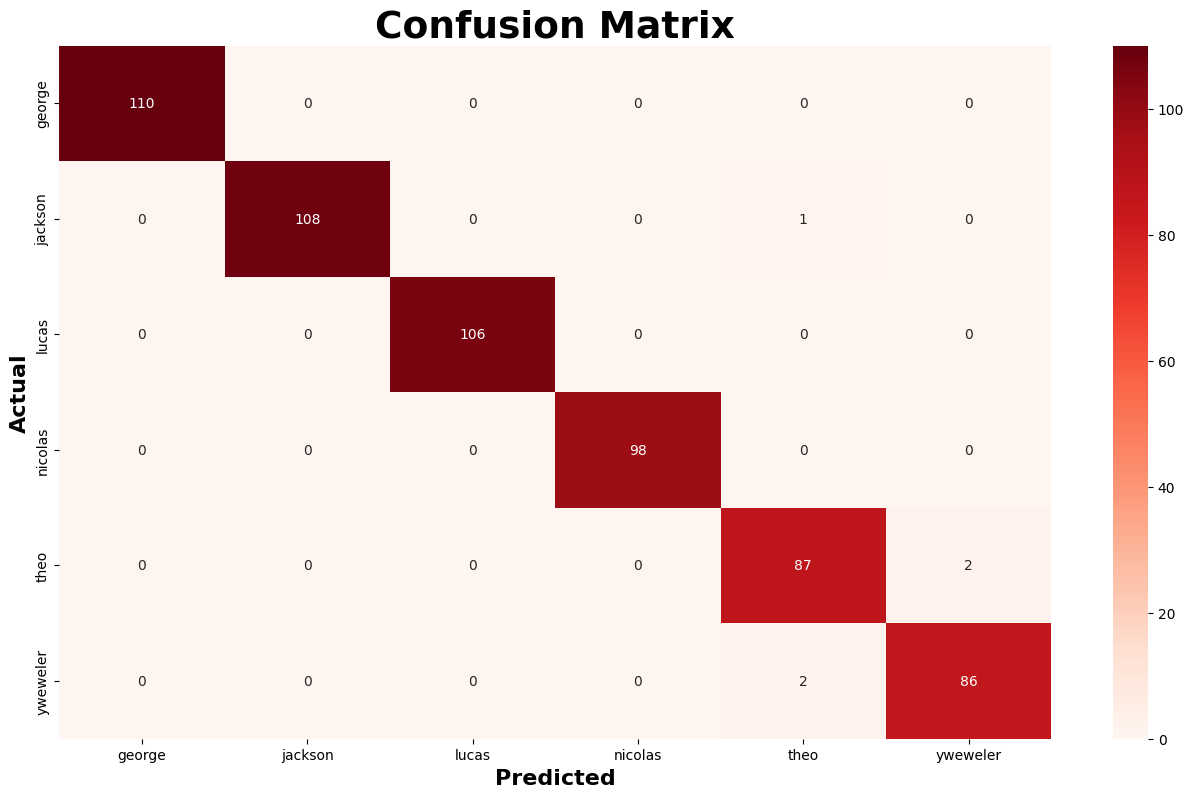

Testing with a sample audio file...
Predicted Speaker: lucas


In [4]:
# ======================================================
# Script for FSDD Dataset Analysis and Classification with Hyperparameter Tuning
# ======================================================
#
# @Author: Priyanka A
# @Date: 2024-12-23
#
# @Description:
# This script processes the Free Spoken Digit Dataset (FSDD), extracts MFCC features,
# trains an SVM classifier to recognize speakers, evaluates its performance,
# and visualizes results. Includes cross-validation, hyperparameter tuning,
# and prediction for test audio.
#
# @ONLINE: {Free Spoken Digit Dataset,
#     author = "Zohar Jackson",
#     title  = "Spoken_Digit",
#     year   = "2016",
#     url    = "https://github.com/Jakobovski/free-spoken-digit-dataset"
#   }
# ======================================================

# Step 1: Install Necessary Libraries (if not already installed)
!pip install librosa scikit-learn numpy matplotlib seaborn joblib

# Step 2: Download the FSDD Dataset
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

# Step 3: Import Libraries
import os
import numpy as np
import librosa
import librosa.display
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Step 4: Define Dataset Path
AUDIO_FOLDER = "/content/free-spoken-digit-dataset/recordings"


def extract_features(folder_path):
    """
    Extract MFCC features and speaker labels from audio files in the specified folder.

    Args:
        folder_path (str): Path to the folder containing audio files.

    Returns:
        tuple: Features (X) as a numpy array and labels (y) as a numpy array.
    """
    features, labels = [], []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".wav"):
            file_path = os.path.join(folder_path, file_name)
            audio, sr = librosa.load(file_path, sr=None)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            mfccs_mean = np.mean(mfccs.T, axis=0)
            features.append(mfccs_mean)
            labels.append(file_name.split("_")[1])  # Extract speaker label
    return np.array(features), np.array(labels)


def encode_labels(labels):
    """
    Encode string labels into numeric values.

    Args:
        labels (array-like): List or array of string labels.

    Returns:
        tuple: Encoded labels as numpy array and the LabelEncoder object.
    """
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    return encoded_labels, encoder


def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plot a confusion matrix for the classifier's predictions.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        labels (list): List of label names.

    Returns:
        None
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(16, 9))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted', fontsize=16, fontweight="bold")
    plt.ylabel('Actual', fontsize=16, fontweight="bold")
    plt.title('Confusion Matrix', fontsize=27, fontweight="bold")
    plt.show()



def predict_speaker(file_path, model, encoder, scaler):
    """
    Predict the speaker of a given audio file.

    Args:
        file_path (str): Path to the audio file.
        model: Trained model for prediction.
        encoder: LabelEncoder object for decoding predictions.
        scaler: StandardScaler object for feature scaling.

    Returns:
        str: Predicted speaker label.
    """
    audio, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs.T, axis=0).reshape(1, -1)
    mfccs_scaled = scaler.transform(mfccs_mean)
    prediction = model.predict(mfccs_scaled)
    return encoder.inverse_transform(prediction)


# Step 5: Load and Extract MFCC Features
print("Extracting features...")
X, y = extract_features(AUDIO_FOLDER)

# Step 6: Encode Labels
print("Encoding labels...")
y_encoded, label_encoder = encode_labels(y)

# Step 7: Split Data into Training and Testing Sets
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Step 8: Normalize Features
print("Scaling features...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 9: Train an SVM Classifier with Hyperparameter Tuning
print("Tuning hyperparameters and training SVM classifier...")
param_grid = {
    'C': [1.0, 10.0, 100.0, 227.0],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
classifier = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Step 10: Evaluate the Classifier
print("Evaluating classifier...")
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Step 11: Save the Model and Scaler
print("Saving model and scaler...")
joblib.dump(classifier, 'svm_speaker_recognition.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Step 12: Visualize Confusion Matrix
print("Visualizing confusion matrix...")
plot_confusion_matrix(y_test, y_pred, label_encoder.classes_)

# Step 13: Test Prediction with a New Audio File
print("Testing with a sample audio file...")
sample_file = os.path.join(AUDIO_FOLDER, os.listdir(AUDIO_FOLDER)[0])
predicted_speaker = predict_speaker(sample_file, classifier, label_encoder, scaler)
print(f"Predicted Speaker: {predicted_speaker[0]}")


# ======================================================
# End of Script
# ======================================================


# Baseline model

fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.
Extracting features...


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2020
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1455
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1359
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2045
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1858
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1556
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py

Encoding labels...
Splitting data...
Training SVM classifier...
Evaluating classifier...
Accuracy: 98.17%
Classification Report:
              precision    recall  f1-score   support

      george       1.00      1.00      1.00       110
     jackson       1.00      0.99      1.00       109
       lucas       0.99      0.97      0.98       106
     nicolas       1.00      1.00      1.00        98
        theo       0.95      0.97      0.96        89
    yweweler       0.94      0.95      0.95        88

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Visualizing confusion matrix...


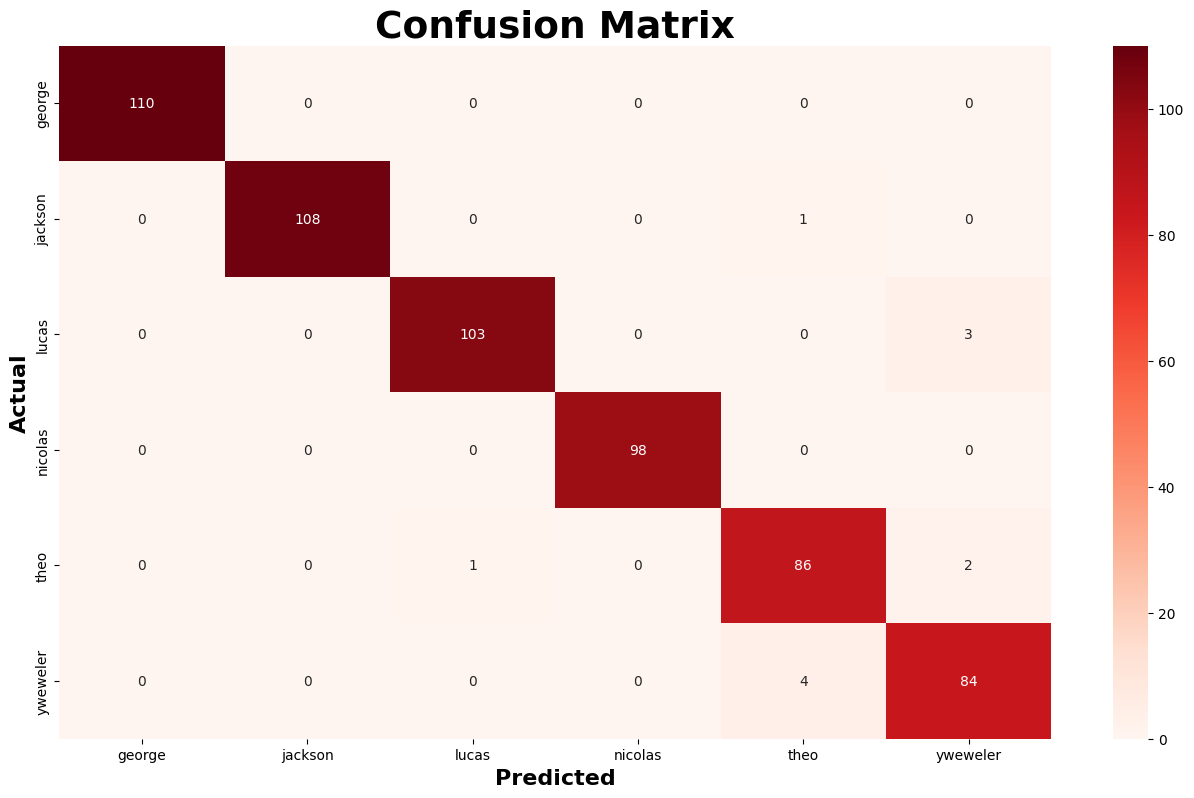

In [5]:
# ======================================================
# Script for FSDD Dataset Analysis and Classification- Without Hyperparameter tuning
# ======================================================
#
# @Author: Priyanka A
# @Date: 2024-12-23
#
# @Description:
# This script processes the Free Spoken Digit Dataset (FSDD), extracts MFCC features,
# trains a baseline SVM classifier to recognize speakers, and evaluates its performance.
# The script also visualizes the confusion matrix.
#
# ======================================================

# Step 1: Install Necessary Libraries (if not already installed)
!pip install librosa scikit-learn numpy matplotlib seaborn

# Step 2: Download the FSDD Dataset
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

# Step 3: Import Libraries
import os
import numpy as np
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Define Dataset Path
AUDIO_FOLDER = "/content/free-spoken-digit-dataset/recordings"


def extract_features(folder_path):
    """
    Extract MFCC features and speaker labels from audio files in the specified folder.

    Args:
        folder_path (str): Path to the folder containing audio files.

    Returns:
        tuple: Features (X) as a numpy array and labels (y) as a numpy array.
    """
    features, labels = [], []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".wav"):
            file_path = os.path.join(folder_path, file_name)
            audio, sr = librosa.load(file_path, sr=None)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            mfccs_mean = np.mean(mfccs.T, axis=0)
            features.append(mfccs_mean)
            labels.append(file_name.split("_")[1])  # Extract speaker label
    return np.array(features), np.array(labels)


def encode_labels(labels):
    """
    Encode string labels into numeric values.

    Args:
        labels (array-like): List or array of string labels.

    Returns:
        tuple: Encoded labels as numpy array and the LabelEncoder object.
    """
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    return encoded_labels, encoder


def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plot a confusion matrix for the classifier's predictions.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        labels (list): List of label names.

    Returns:
        None
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(16, 9))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted', fontsize=16, fontweight="bold")
    plt.ylabel('Actual', fontsize=16, fontweight="bold")
    plt.title('Confusion Matrix', fontsize=27, fontweight="bold")
    plt.show()


# Step 5: Load and Extract MFCC Features
print("Extracting features...")
X, y = extract_features(AUDIO_FOLDER)

# Step 6: Encode Labels
print("Encoding labels...")
y_encoded, label_encoder = encode_labels(y)

# Step 7: Split Data into Training and Testing Sets
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Step 8: Train an SVM Classifier
print("Training SVM classifier...")
classifier = SVC(C=227.0, kernel="rbf", probability=True, random_state=42)
classifier.fit(X_train, y_train)

# Step 9: Evaluate the Classifier
print("Evaluating classifier...")
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Step 10: Visualize Confusion Matrix
print("Visualizing confusion matrix...")
plot_confusion_matrix(y_test, y_pred, label_encoder.classes_)


# ======================================================
# End of Script
# ======================================================
